# Traffic Density Vs Weather Variables
    Joseph Antony
    20th June 2023

In [1]:
import warnings
import numpy as np

from datetime import datetime, timedelta

import pandas as pd

import polars as pl
pl.enable_string_cache(True)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks", palette="muted", color_codes=True)

warnings.filterwarnings("ignore")

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.weight'] = 'bold'

In [2]:
%%time

select_Cols = ['DATE_TIME', 'GEOHASH', 'NUMBER_OF_VEHICLES', 'DISTRICT', 'IS_COVID_RESTRICTION', 'HOLIDAY_NAME']
weather_cols = ['TEMP', 'PRCP', 'RAIN', 'SNOW', 'WINDSPEED', 'HUMIDITY']
weather_cat = ['WTHR_CAT']


pl_df = (
    pl.scan_parquet("datasets/00_tr_df_merged/tr_ist_td_merged_full.zstd")
    .select(select_Cols + weather_cols + weather_cat)
    .with_columns(pl.col('DATE_TIME').dt.date().alias('DATE'),
                  pl.col('DATE_TIME').dt.hour().alias('HOUR').cast(pl.UInt8),
                  pl.col('DATE_TIME').dt.month().alias('MONTH').cast(pl.UInt8),
                  pl.col('DATE_TIME').dt.year().alias('YEAR').cast(pl.UInt16),
                  pl.col('DATE_TIME').dt.weekday().alias('DAYOFWEEK').cast(pl.UInt8))
    .with_columns(pl.when(pl.col('HOLIDAY_NAME').ne('Non Holiday'))
                  .then(1)
                  .otherwise(0)
                  .alias('IS_HOLIDAY')
                  .cast(pl.Boolean))
    .drop('HOLIDAY_NAME')
).collect(streaming=True)

pl_df.head()

Wall time: 48.4 s


DATE_TIME,GEOHASH,NUMBER_OF_VEHICLES,DISTRICT,IS_COVID_RESTRICTION,TEMP,PRCP,RAIN,SNOW,WINDSPEED,HUMIDITY,WTHR_CAT,DATE,HOUR,MONTH,YEAR,DAYOFWEEK,IS_HOLIDAY
datetime[ns],cat,u16,cat,bool,f32,f32,f32,f32,f32,u8,cat,date,u8,u8,u16,u8,bool
2020-01-01 00:00:00,"""sxkbj3""",97,"""Gebze""",false,5.8,0.0,0.0,0.0,14.9,88,"""normal""",2020-01-01,0,1,2020,3,true
2020-01-01 01:00:00,"""sxkbj3""",58,"""Gebze""",false,6.0,0.0,0.0,0.0,16.1,87,"""normal""",2020-01-01,1,1,2020,3,true
2020-01-01 02:00:00,"""sxkbj3""",40,"""Gebze""",false,6.1,0.0,0.0,0.0,18.6,86,"""normal""",2020-01-01,2,1,2020,3,true
2020-01-01 03:00:00,"""sxkbj3""",33,"""Gebze""",false,6.0,0.0,0.0,0.0,19.799999,85,"""normal""",2020-01-01,3,1,2020,3,true
2020-01-01 04:00:00,"""sxkbj3""",25,"""Gebze""",false,5.9,0.0,0.0,0.0,20.5,85,"""normal""",2020-01-01,4,1,2020,3,true


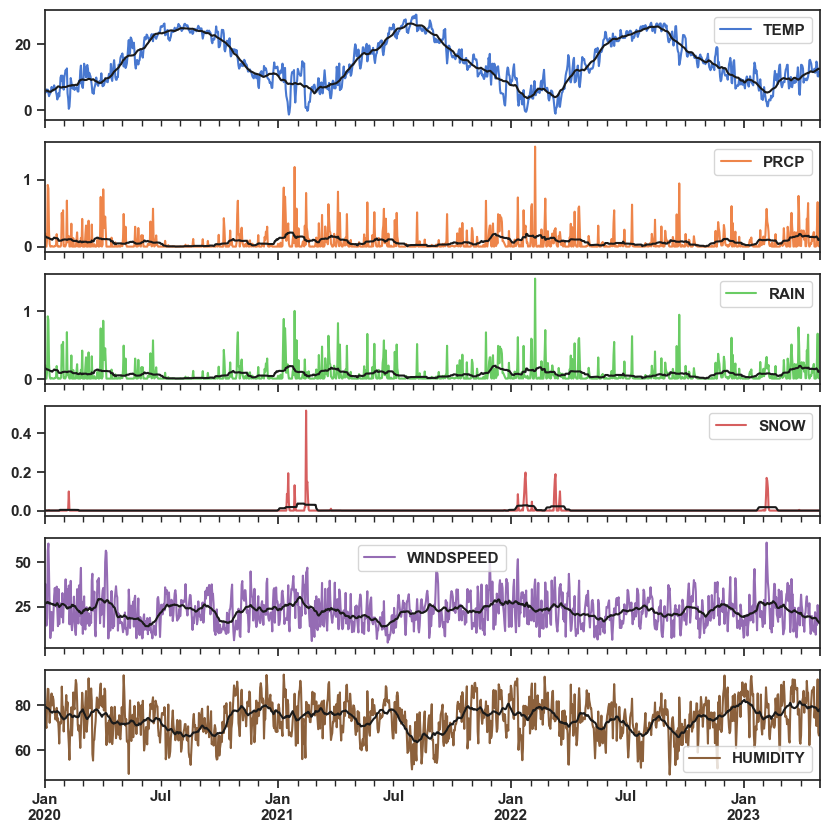

In [3]:
# Daily mean weather conditions

ax = (
    pl_df.lazy()
    .groupby('DATE')
    .agg(pl.col(weather_cols).mean())
    .sort('DATE')
    .collect(streaming=True)
    .to_pandas()
    .set_index('DATE')
    .plot(subplots=True, figsize=(10, 10), xlabel="")
)

(
    pl_df.lazy()
    .groupby('DATE')
    .agg(pl.col(weather_cols).mean())
    .sort('DATE')
    .with_columns(pl.exclude('DATE').rolling_mean(window_size=30, min_periods=7, center=True))
    .collect(streaming=True)
    .to_pandas()
    .set_index('DATE')
    .plot(subplots=True, ax=ax, color='k', legend=False, xlabel="")
);

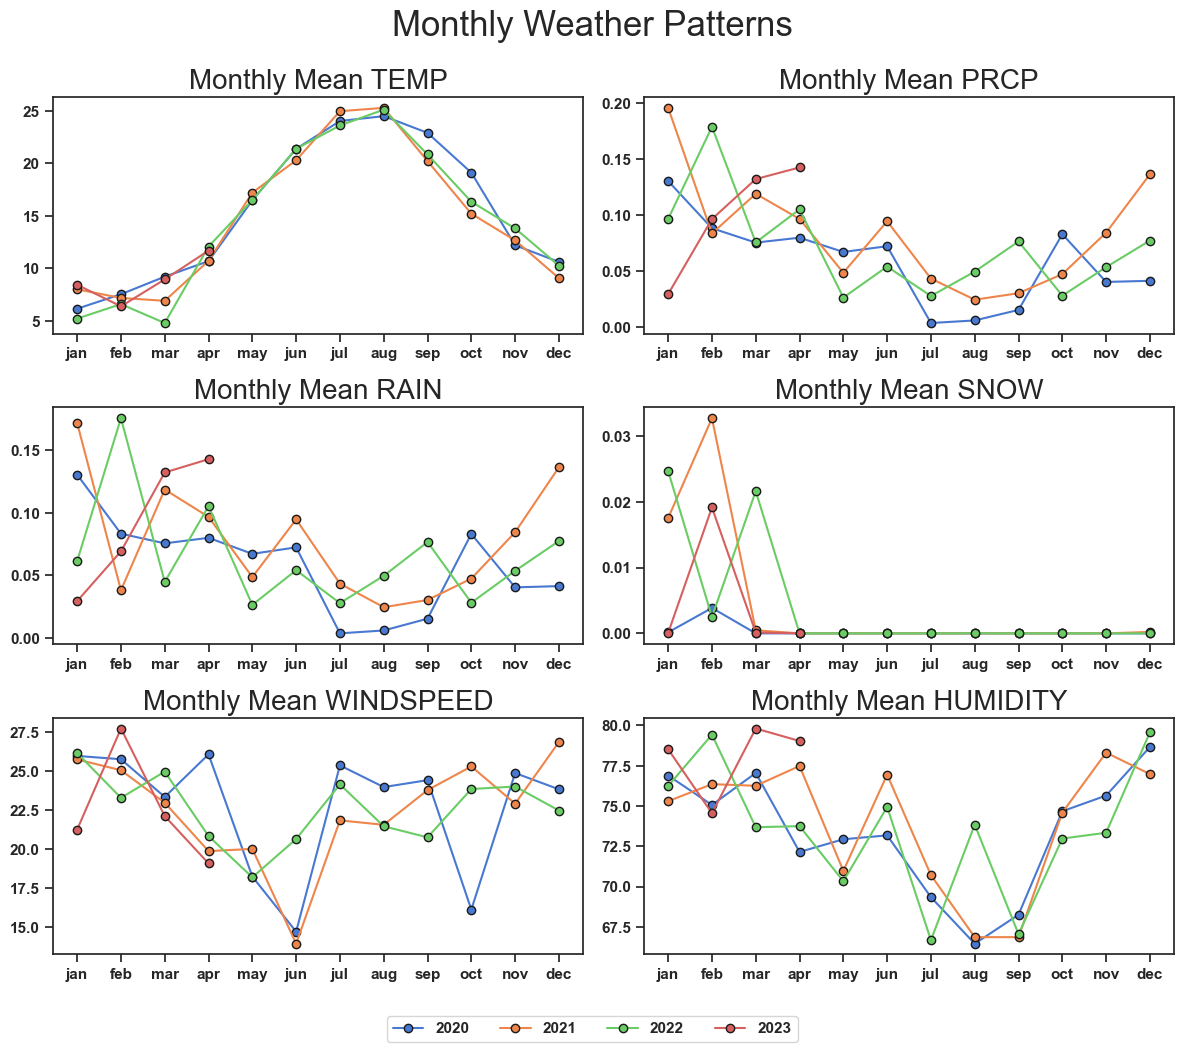

In [4]:
# Checking for monthly seasonality pattern

month_labels=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

temp_df = (
    pl_df.lazy()
    .groupby(['YEAR', 'MONTH'])
    .agg(pl.col(weather_cols).mean())
    .sort(['YEAR', 'MONTH'])
    .collect(streaming=True)
)

fig, axes = plt.subplots(3, 2, tight_layout=True, figsize=(12, 10))

for col, ax in zip(weather_cols, axes.flatten()):
    
    (
        temp_df.select(['YEAR', 'MONTH', col])
        .pivot(index='MONTH', columns='YEAR', values=col)
        .to_pandas()
        .set_index('MONTH')
        .plot(ax=ax, marker="o", mec="k", legend=False)
    )
    
    ax.set_xticks(np.arange(1, 13, 1), labels=month_labels)
    ax.set_title(f'Monthly Mean {col}')
    ax.set_xlabel("")

# To display Month legends
handles, _ = axes.flatten()[0].get_legend_handles_labels()
fig.legend(handles=handles, labels=[2020, 2021, 2022, 2023], loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.05))

plt.suptitle("Monthly Weather Patterns", fontsize=25, y=0.99);

    Lowest Temperatures are observed on month from Jan to March and higher temperatures are observed during July and August. Precipitation (Rain & snowfall) are highest from Jan to March. Windspeed are usually lowest at around May and June.

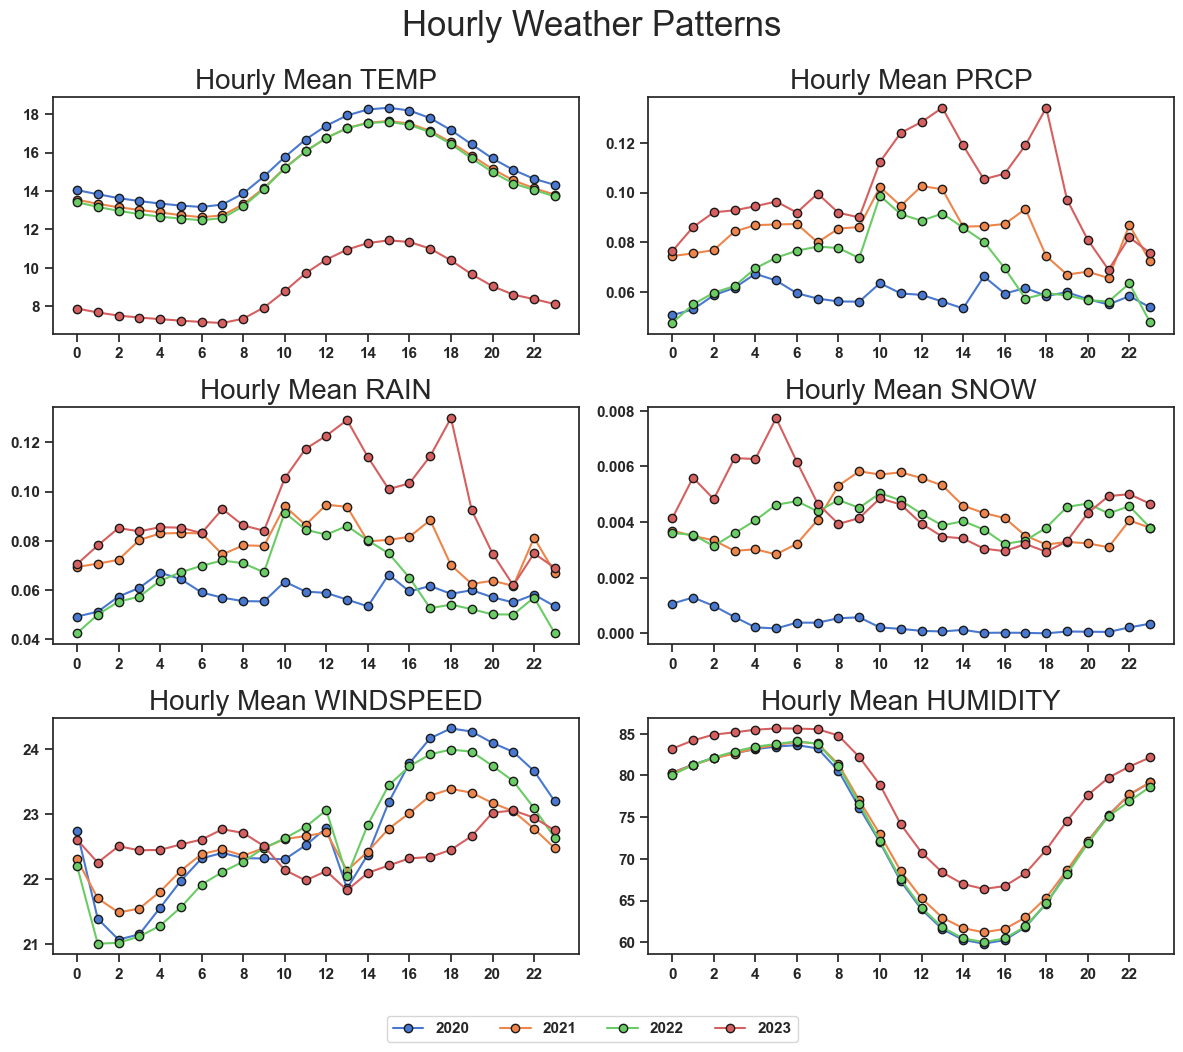

In [5]:
# Checking for hourly seasonality pattern

temp_df = (
    pl_df.lazy()
    .groupby(['YEAR', 'HOUR'])
    .agg(pl.col(weather_cols).mean())
    .sort(['YEAR', 'HOUR'])
    .collect(streaming=True)
)

fig, axes = plt.subplots(3, 2, tight_layout=True, figsize=(12, 10))

for col, ax in zip(weather_cols, axes.flatten()):
    
    (
        temp_df.select(['YEAR', 'HOUR', col])
        .pivot(index='HOUR', columns='YEAR', values=col)
        .to_pandas()
        .set_index('HOUR')
        .plot(ax=ax, marker="o", mec="k", legend=False)
    )
    
    ax.set_xticks(np.arange(0, 24, 2))
    ax.set_title(f'Hourly Mean {col}')
    ax.set_xlabel("")

# To display Month legends
handles, _ = axes.flatten()[0].get_legend_handles_labels()
fig.legend(handles=handles, labels=[2020, 2021, 2022, 2023], loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.05))

plt.suptitle("Hourly Weather Patterns", fontsize=25, y=0.99);

### Daily Mean Traffic Density Vs Weather

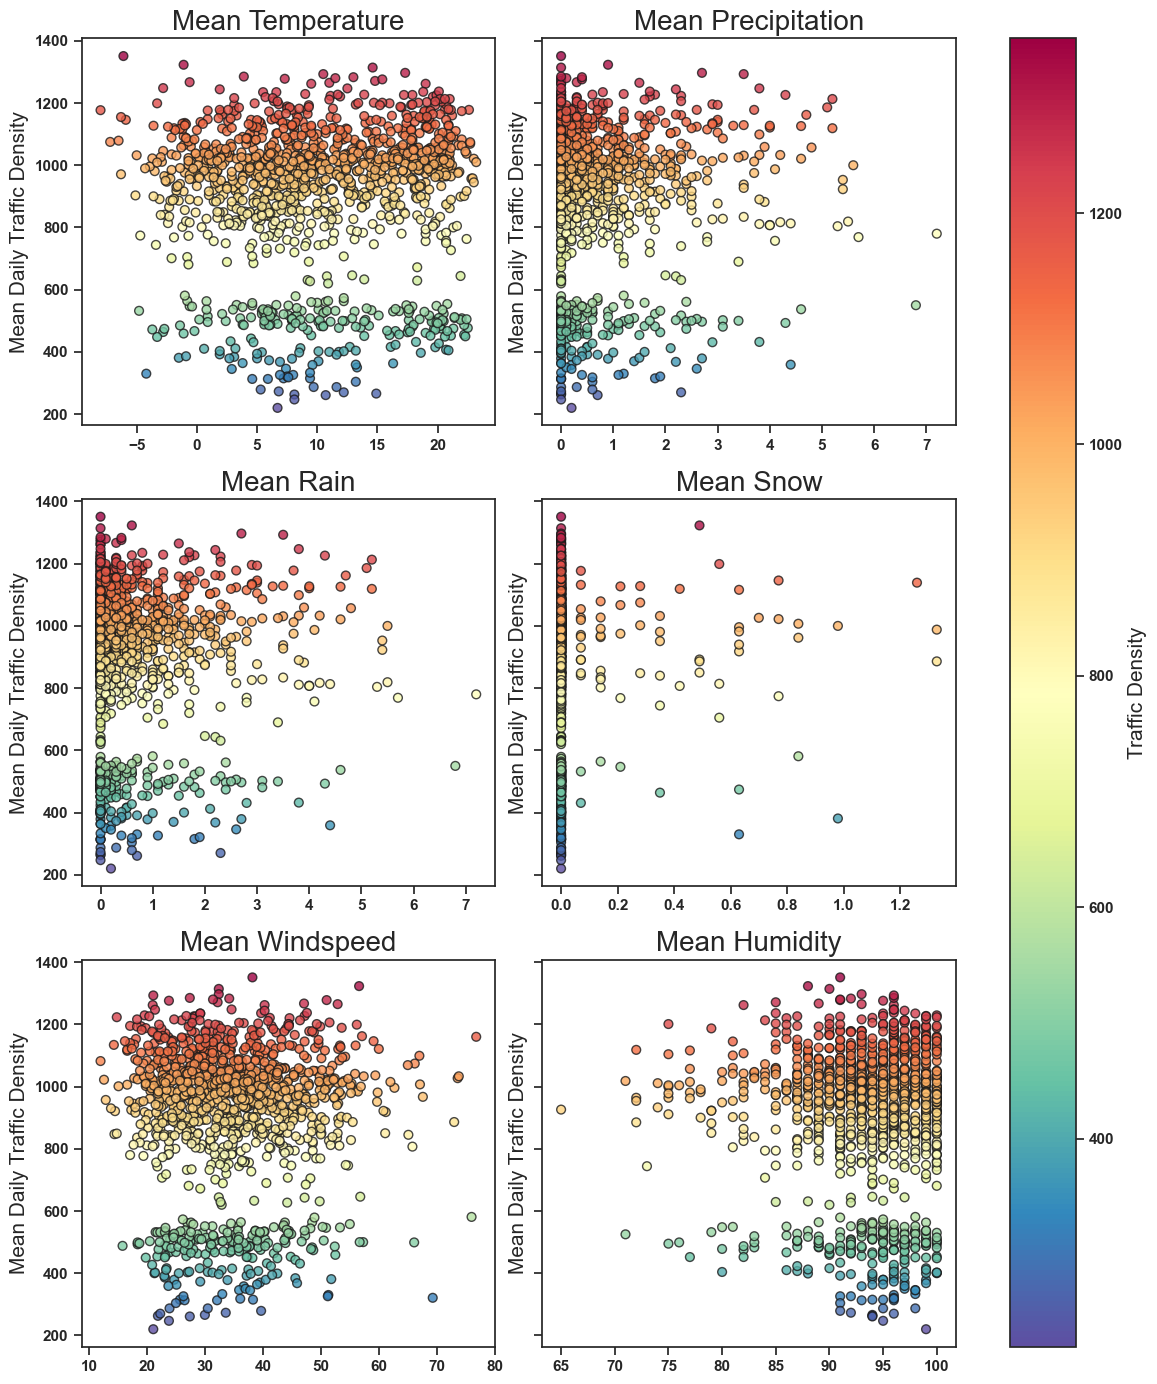

In [6]:
wthr_dict = {"TEMP" : "Temperature", 
             "PRCP" : "Precipitation", 
             "RAIN": "Rain", 
             "SNOW" : "Snow", 
             "WINDSPEED" : "Windspeed",
             "HUMIDITY" : "Humidity"}

temp_df = (
    pl_df.lazy()
    .groupby('DATE')
    .agg(pl.col('NUMBER_OF_VEHICLES').max(),
         pl.col('TEMP').min(),
         pl.col('PRCP').max(),
         pl.col('RAIN').max(),
         pl.col('SNOW').max(),
         pl.col('WINDSPEED').max(),
         pl.col('HUMIDITY').max())
    .collect(streaming=True)
    .to_pandas()
)

cmap = plt.cm.get_cmap('Spectral_r')
vmin, vmax = temp_df['NUMBER_OF_VEHICLES'].min(), temp_df['NUMBER_OF_VEHICLES'].max()
norm = plt.Normalize(vmin=vmin, vmax=vmax)
colors = cmap(norm(temp_df['NUMBER_OF_VEHICLES']))

fig, axes = plt.subplots(3, 2, figsize=(12, 14), sharey=True)

for col, ax in zip(weather_cols, axes.flatten()):
    
    cax = ax.scatter(x=col, y='NUMBER_OF_VEHICLES', data=temp_df, edgecolor='k',
                     alpha=0.8, s=40, c=colors, cmap=cmap)

    ax.set_ylabel(f"Mean Daily Traffic Density")
    ax.set_title(f"Mean {wthr_dict[col]}");

fig.tight_layout()

# Add common color bar at the bottom
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=axes.ravel().tolist(), pad=0.05)
cbar.set_label('Traffic Density')

The above is a scatterplot illustrating the relationship between daily mean traffic density and daily mean weather variables. **The color scale indicates the intensity of traffic density, with red representing the highest density and purple indicating the lowest density**.

Upon examining the plots, **we can identify two distinct groups of data points**. The first group consists of red and yellow points located at the upper level of the plots, while the second group comprises bluish-purple regions situated in the lower areas. **The blue-purple regions correspond to days that are either weekends, specific holidays (such as Ramadan holidays), or during periods of COVID lockdowns**.

As previously noted, these **blue-purple regions indicate days with the lowest traffic density**. Therefore, across all plots, we consistently observe these two clusters.

When analyzing the plot of Temperature versus Traffic Density, we notice that the data points are evenly distributed across the entire temperature range. However, **there are a few dark red dots located at the top left corner, where the temperature was around -5°C**. This could possibly suggest a single event when traffic was high due to extreme cold, possibly related to snowfall.

In fact, this pattern is observed across all variables. **The data points exhibit a uniform distribution, making it challenging to identify a specific pattern indicating how particular weather conditions affect traffic density**.

Furthermore, it is **difficult to ascertain whether weather directly caused a decrease in traffic density, as the period from November 2020 to February 2021, typically the winter months, coincided with COVID-related restrictions**, resulting in lower-than-usual traffic density.

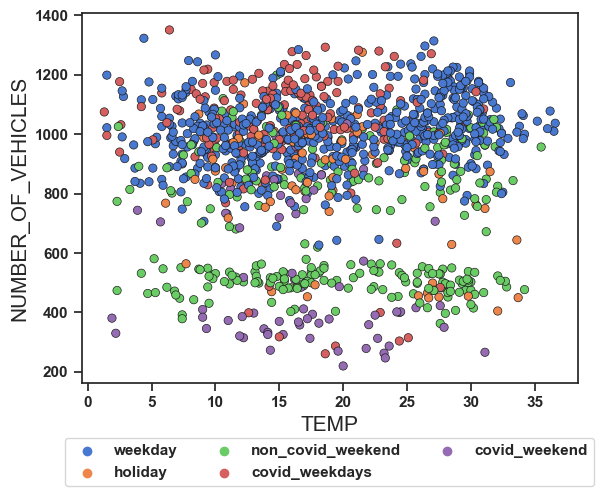

In [7]:


temp_df = (
    pl_df.lazy()
    .groupby(['DATE', 'DAYOFWEEK', 'IS_COVID_RESTRICTION', 'IS_HOLIDAY'])
    .agg(pl.col(['NUMBER_OF_VEHICLES'] + weather_cols).max())
    .with_columns(pl.when(pl.col('DAYOFWEEK').is_in([6, 7]) & pl.col('IS_COVID_RESTRICTION').eq('true'))
                  .then('covid_weekend')
                  .when(pl.col('DAYOFWEEK').is_in([6, 7]) & pl.col('IS_COVID_RESTRICTION').eq('false'))
                  .then('non_covid_weekend')
                  .when(~pl.col('DAYOFWEEK').is_in([6, 7]) & pl.col('IS_COVID_RESTRICTION').eq('true'))
                  .then('covid_weekdays')
                  .when(~pl.col('DAYOFWEEK').is_in([6, 7]) & pl.col('IS_HOLIDAY').eq('true'))
                  .then('holiday')
                  .otherwise('weekday')
                  .alias('DAY_TYPE'))
    .collect(streaming=True)
    .to_pandas()
)

ax = sns.scatterplot(
    x='TEMP',
    y='NUMBER_OF_VEHICLES',
    hue='DAY_TYPE',
    data=temp_df,
    edgecolor='k',
)

ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.3));

    The above plot is a close up of the mean traffic density and mean daily temperature in order to examine these 2 clusters. As is obvious in the legends, most of the lower cluster of data is made of days that is either a weekend (where we know traffic density is lowest during weekends), weekdays and weekends when it was a COVID restriction/lockdown and certain holidays such as Ramadan, where the median traffic density is lowest compared to other holidays.

In [8]:
(
    pl_df.lazy()
    .groupby(['GEOHASH', 'DISTRICT'])
    .agg(pl.col('NUMBER_OF_VEHICLES').max())
    .top_k(5, by='NUMBER_OF_VEHICLES')
    .collect(streaming=True)
)

GEOHASH,DISTRICT,NUMBER_OF_VEHICLES
cat,cat,u16
"""sxk3xe""","""Başakşehir""",1351
"""sxkbhn""","""Çayırova""",1323
"""sxkb6p""","""Pendik""",1244
"""sxk985""","""Bağcılar""",1225
"""sxk3xd""","""Bağcılar""",1205


In [54]:
(
    pl_df['SNOW'].max()
)

1.3300000429153442

In [52]:
with pl.Config(
    tbl_rows=24,
    tbl_formatting="ASCII_FULL_CONDENSED",
    tbl_hide_column_data_types=True,
    tbl_hide_dataframe_shape=True,
):
    print(
        pl_df.lazy()
        .filter(pl.col('GEOHASH').eq('sxk3xd') & 
                pl.col('DATE_TIME').is_between(datetime(2021, 1, 27), datetime(2021, 1, 28)))
        .select(pl.col(['DATE_TIME', 'NUMBER_OF_VEHICLES', 'SNOW', 'WTHR_CAT']))
        .collect(streaming=True)
    )

+---------------------+--------------------+------+---------------+
| DATE_TIME           | NUMBER_OF_VEHICLES | SNOW | WTHR_CAT      |
+=================================================================+
| 2021-01-27 00:00:00 | 154                | 0.0  | normal        |
| 2021-01-27 01:00:00 | 146                | 0.0  | light_drizzle |
| 2021-01-27 02:00:00 | 127                | 0.0  | heavy_drizzle |
| 2021-01-27 03:00:00 | 121                | 0.0  | light_rain    |
| 2021-01-27 04:00:00 | 158                | 0.0  | light_rain    |
| 2021-01-27 05:00:00 | 356                | 0.0  | moderate_rain |
| 2021-01-27 06:00:00 | 954                | 0.0  | moderate_rain |
| 2021-01-27 07:00:00 | 729                | 0.0  | moderate_rain |
| 2021-01-27 08:00:00 | 547                | 0.0  | moderate_rain |
| 2021-01-27 09:00:00 | 674                | 0.0  | moderate_rain |
| 2021-01-27 10:00:00 | 690                | 0.14 | light_snow    |
| 2021-01-27 11:00:00 | 643                | 0.7

In [9]:
def scale_cols(x):
    return (x-x.min())/(x.max()-x.min())

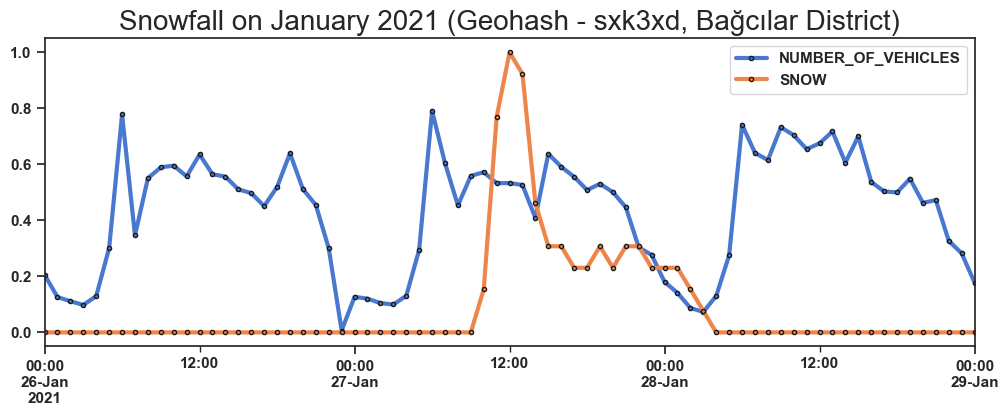

In [38]:
ax = (
    pl_df.lazy()
    .filter(pl.col('GEOHASH').eq('sxk3xd'))
    .select('DATE_TIME', scale_cols(pl.col(['NUMBER_OF_VEHICLES', 'SNOW'])))
    .groupby('DATE_TIME')
    .agg(pl.col('NUMBER_OF_VEHICLES').mean(), pl.col('SNOW').mean())
    .sort('DATE_TIME')
    .collect(streaming=True)
    .to_pandas()
    .set_index('DATE_TIME')
    .plot(marker='.', mec='k', figsize=(12, 4), lw=3)
)

ax.set_title("Snowfall on January 2021 (Geohash - sxk3xd, Bağcılar District)")
ax.set_xlabel("")
ax.set_xlim("2021-01-26", "2021-01-29");

    The above plot zooms in during a particular week of a GEOHASH when the snowfall was high and the hourly traffic density.When comparing the hourly pattern of other days, it is not immediatly clear if a heavy snow fall affects the traffic density.

In [55]:
with pl.Config(
    tbl_rows=24,
    tbl_formatting="ASCII_MARKDOWN",
    tbl_hide_column_data_types=True,
    tbl_hide_dataframe_shape=True,
):
    print(
        pl_df.lazy()
        .filter(pl.col('GEOHASH').eq('sxk3xd') & 
                pl.col('DATE_TIME').is_between(datetime(2022, 1, 23), datetime(2022, 1, 24)))
        .select(pl.col(['DATE_TIME', 'NUMBER_OF_VEHICLES', 'SNOW', 'WTHR_CAT']))
        .collect(streaming=True)
    )

| DATE_TIME           | NUMBER_OF_VEHICLES | SNOW | WTHR_CAT      |
|---------------------|--------------------|------|---------------|
| 2022-01-23 00:00:00 | 292                | 0.0  | normal        |
| 2022-01-23 01:00:00 | 222                | 0.07 | light_snow    |
| 2022-01-23 02:00:00 | 140                | 0.14 | light_snow    |
| 2022-01-23 03:00:00 | 81                 | 0.28 | moderate_snow |
| 2022-01-23 04:00:00 | 1                  | 0.21 | moderate_snow |
| 2022-01-23 05:00:00 | 197                | 0.21 | moderate_snow |
| 2022-01-23 06:00:00 | 258                | 0.21 | moderate_snow |
| 2022-01-23 07:00:00 | 299                | 0.28 | moderate_snow |
| 2022-01-23 08:00:00 | 299                | 0.28 | moderate_snow |
| 2022-01-23 09:00:00 | 294                | 0.14 | light_snow    |
| 2022-01-23 10:00:00 | 189                | 0.07 | light_snow    |
| 2022-01-23 11:00:00 | 254                | 0.07 | light_snow    |
| 2022-01-23 12:00:00 | 256                | 0.0

In [59]:
with pl.Config(
    tbl_rows=24,
    tbl_formatting="ASCII_MARKDOWN",
    tbl_hide_column_data_types=True,
    tbl_hide_dataframe_shape=True,
):
    print(
        pl_df.lazy()
        .filter(pl.col('GEOHASH').eq('sxk3xd') & 
                pl.col('DATE_TIME').is_between(datetime(2022, 1, 24), datetime(2022, 1, 25)))
        .select(pl.col(['DATE_TIME', 'NUMBER_OF_VEHICLES', 'SNOW', 'WTHR_CAT']))
        .collect(streaming=True)
    )

| DATE_TIME           | NUMBER_OF_VEHICLES | SNOW | WTHR_CAT      |
|---------------------|--------------------|------|---------------|
| 2022-01-24 00:00:00 | 289                | 0.07 | light_snow    |
| 2022-01-24 01:00:00 | 148                | 0.07 | light_snow    |
| 2022-01-24 02:00:00 | 126                | 0.07 | light_snow    |
| 2022-01-24 03:00:00 | 124                | 0.07 | light_snow    |
| 2022-01-24 04:00:00 | 2                  | 0.14 | light_snow    |
| 2022-01-24 05:00:00 | 186                | 0.21 | moderate_snow |
| 2022-01-24 06:00:00 | 763                | 0.21 | moderate_snow |
| 2022-01-24 07:00:00 | 1011               | 0.28 | moderate_snow |
| 2022-01-24 08:00:00 | 775                | 0.21 | moderate_snow |
| 2022-01-24 09:00:00 | 595                | 0.21 | moderate_snow |
| 2022-01-24 10:00:00 | 894                | 0.28 | moderate_snow |
| 2022-01-24 11:00:00 | 653                | 0.28 | moderate_snow |
| 2022-01-24 12:00:00 | 788                | 0.3

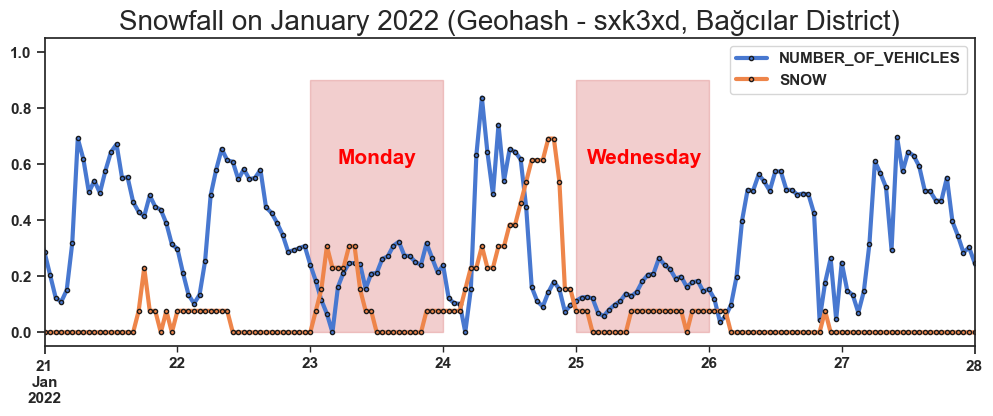

In [74]:
ax = (
    pl_df.lazy()
    .filter(pl.col('GEOHASH').eq('sxk3xd'))
    .select('DATE_TIME', scale_cols(pl.col(['NUMBER_OF_VEHICLES', 'SNOW'])))
    .groupby('DATE_TIME')
    .agg(pl.col('NUMBER_OF_VEHICLES').mean(), pl.col('SNOW').mean())
    .sort('DATE_TIME')
    .collect(streaming=True)
    .to_pandas()
    .set_index('DATE_TIME')
    .plot(marker='.', mec='k', figsize=(12, 4), lw=3)
)

ax.fill_between(x=("2022-01-23", "2022-01-24"), y1=0.0, y2=0.9, color='r', alpha = 0.3)
ax.text("2022-01-23 05:00:00", 0.6, "Monday", fontsize=15, c='red')

ax.fill_between(x=("2022-01-25", "2022-01-26"), y1=0.0, y2=0.9, color='r', alpha = 0.3)
ax.text("2022-01-25 02:30:00", 0.6, "Wednesday", fontsize=15, c='red')

ax.set_title("Snowfall on January 2022 (Geohash - sxk3xd, Bağcılar District)")
ax.set_xlabel("")
ax.set_xlim("2022-01-21", "2022-01-28");

In [75]:
def wthr_cat_boxplot(col):

    temp_df = (
        pl_df.lazy()
        .groupby(['DATE_TIME', 'WTHR_CAT'])
        .agg(pl.col(col).mean())
        .collect(streaming=True)
        .to_pandas()
    )

    ax = sns.boxplot(
        x=col,
        y='WTHR_CAT',
        data=temp_df,
        orient='h'
    )

    normal_median = temp_df.query("WTHR_CAT=='normal'")[col].median()

    ax.axvline(normal_median, color='red', linestyle='--', lw=2)

    if col=='NUMBER_OF_VEHICLES':
        ax.set_title("Traffic Density by Weather Type")

    else:
        ax.set_title(f"{col} by Weather Type")

    plt.show();

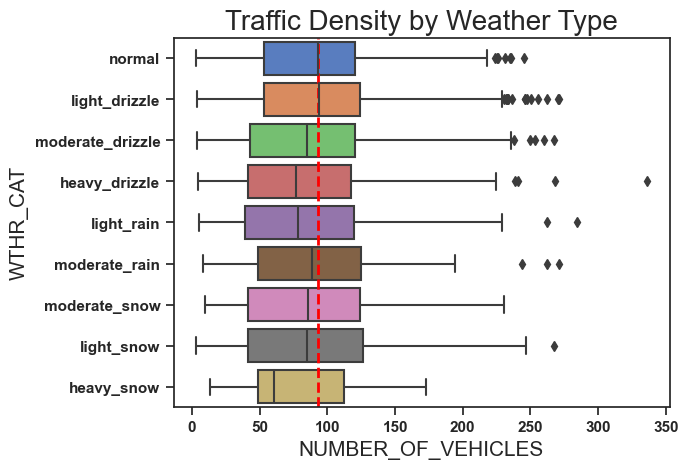

In [76]:
wthr_cat_boxplot('NUMBER_OF_VEHICLES')

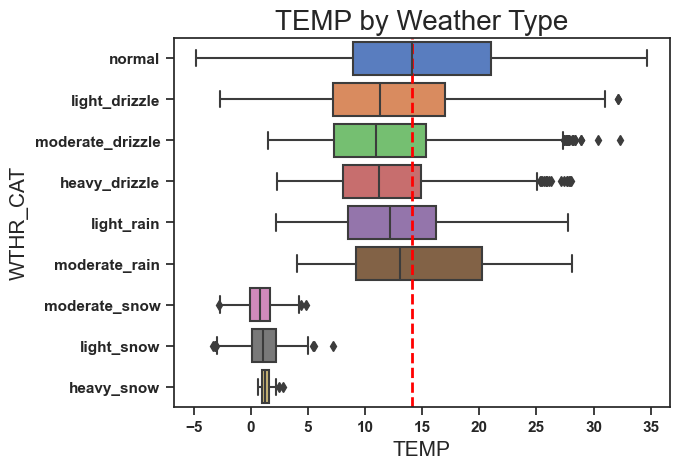

In [14]:
wthr_cat_boxplot('TEMP')

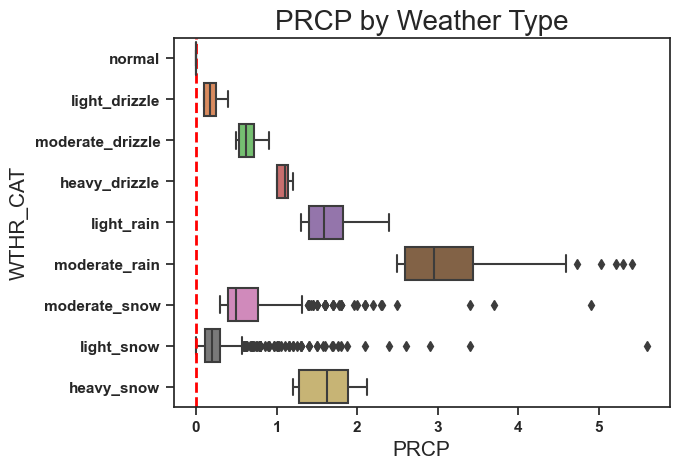

In [15]:
wthr_cat_boxplot('PRCP')

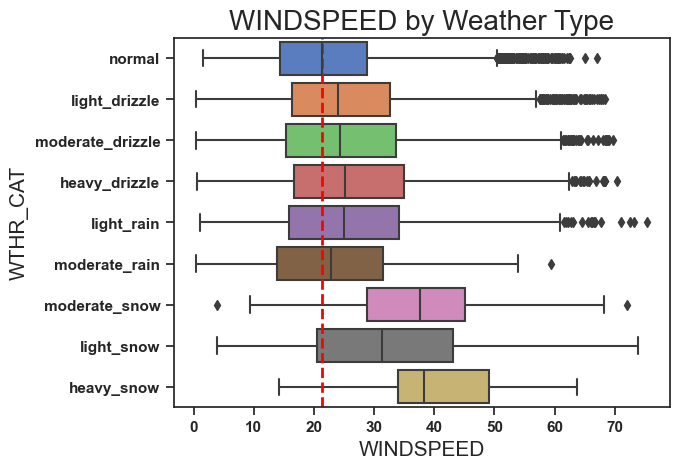

In [16]:
wthr_cat_boxplot('WINDSPEED')

In [17]:
(
    pl_df.lazy()
    .groupby(['DISTRICT', 'GEOHASH'])
    .agg(pl.col(['NUMBER_OF_VEHICLES']).mean())
    .sort(['DISTRICT', 'NUMBER_OF_VEHICLES'], descending=True)
    .with_columns(pl.col('NUMBER_OF_VEHICLES').rank('dense', descending=True).over('DISTRICT').alias('TD_row'))
    .filter(pl.col('TD_row').eq(1))
    .select(['DISTRICT', 'GEOHASH'])
    .collect(streaming=True)
    .to_pandas()
)

,DISTRICT,GEOHASH
0,Çorlu,sx7cu9
1,Kapaklı,sx7ghc
2,Gaziosmanpaşa,sxk99n
3,Bahçelievler,sxk3r9
4,Ergene,sx7fky
5,Zeytinburnu,sxk96h
6,Gebze,sxkbj3
7,Sultanbeyli,sxkc1f
8,Beşiktaş,sxk9u8
9,Çerkezköy,sx7fkw


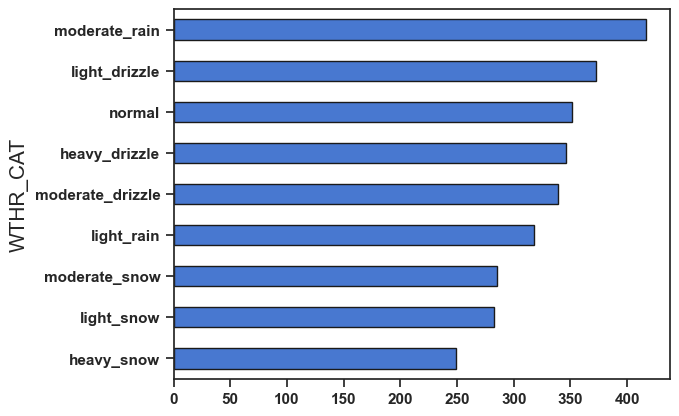

In [18]:
(
    pl_df.lazy()
    .filter(pl.col('GEOHASH').eq('sxk3t9'))
    .groupby('WTHR_CAT')
    .agg(pl.col('NUMBER_OF_VEHICLES').mean())
    .sort('NUMBER_OF_VEHICLES')
    .collect(streaming=True)
    # .select(['DATE_TIME', 'NUMBER_OF_VEHICLES', 'WTHR_CAT'])
    .to_pandas()
    .set_index('WTHR_CAT')
    .plot(kind='barh', edgecolor='k', legend=False)
);